# City bikes in Helsinki and Espoo

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## Data 

The city bike data was downloaded from HSL Open data. https://www.hsl.fi/en/hsl/open-data

It consists of every journey made with the HSL city bikes in Helsinki and Espoo between 2016-2021 and contains the following information

- Departure is the time departure time.
- Return is the time return time.
- Departure_id is the id of the departure station.
- Departure_name is the name of the departure station.
- Return_id is the id of the return station.
- Return_name is the name of the return station.
- Distance is the total distance of the journey in meters.
- Distance is the total time of the journey in seconds.


The weather data was downloaded from Finnish Meteorological Institute. https://en.ilmatieteenlaitos.fi/download-observations

It contains the following observations measured hourly at Helsinki Kaisaniemi station.

- Precip is the precipitation amount during the previous hour in mm.
- Temp is the temperature in Celsius

In [19]:
dtypes = {'Departure': str, 'Return': str, 'Departure_id': str, 'Departure_name': str, 
            'Return_id': str, 'Return_name': str}
bike_df = pd.read_csv('bike_data.csv', dtype=dtypes, parse_dates=['Departure', 'Return'])
bike_df.head()

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration
0,2016-05-02 09:31:00,2016-05-02 09:32:00,A10,Erottaja,A10,Erottaja,2.0,68.0
1,2016-05-02 09:58:00,2016-05-02 09:59:00,A10,Erottaja,A10,Erottaja,2.0,36.0
2,2016-05-02 10:19:00,2016-05-02 10:19:00,A10,Erottaja,A10,Erottaja,0.0,14.0
3,2016-05-02 14:02:00,2016-05-02 14:03:00,997,Workshop Helsinki,997,Workshop Helsinki,2.0,53.0
4,2016-05-02 14:30:00,2016-05-02 14:43:00,997,Workshop Helsinki,997,Workshop Helsinki,1737.0,791.0


In [20]:
weather_df = pd.read_csv('weather_data.csv', parse_dates=['Date'], index_col='Date')
weather_df.head()

,Precip,Temp
Date,,
2016-05-02 09:00:00,0.0,12.0
2016-05-02 10:00:00,0.0,14.1
2016-05-02 11:00:00,0.0,14.5
2016-05-02 12:00:00,0.0,14.6
2016-05-02 13:00:00,0.0,14.3


In [21]:
desc1 = bike_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Bike data')
desc2 = weather_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Weather data')
display_html(desc1._repr_html_()+desc2._repr_html_(), raw=True)

,Distance,Duration
count,15020302.000000,14813569.000000
mean,2303.380268,990.403380
std,22988.385138,9349.491593
min,-4294127.000000,0.000000
25%,1018.000000,350.000000
50%,1774.000000,596.000000
75%,2940.000000,986.000000
max,3681399.000000,5401659.000000
,Precip,Temp
count,29394.000000,29415.000000


## Data Cleaning

Bike data:
Number of rows with missing values: 213845
Percentage of rows with missing values: 0.014
Weather data:
Number of rows with missing values: 67
Percentage of rows with missing values: 0.002


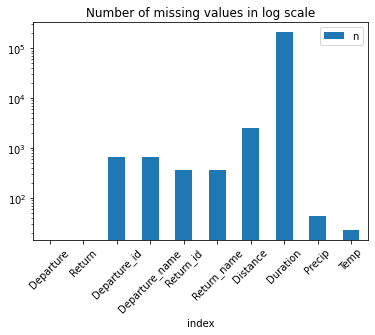

In [22]:
n_missing_bike = np.count_nonzero(bike_df.isnull())
n_missing_weather = np.count_nonzero(weather_df.isnull())
print("Bike data:")
print(f'Number of rows with missing values: {n_missing_bike}')
print(f'Percentage of rows with missing values: {round(n_missing_bike / len(bike_df), 3)}')
print("Weather data:")
print(f'Number of rows with missing values: {n_missing_weather }')
print(f'Percentage of rows with missing values: {round(n_missing_weather / len(weather_df), 3)}')
pd.concat([bike_df.isna().sum().reset_index(name="n"), weather_df.isna().sum().reset_index(name="n")]).plot.bar(x='index', y='n', rot=45, log=True)
plt.title("Number of missing values in log scale")
plt.show()

The duration column is missing significantly more values than the other columns. Since neither of the datasets is missing a large percentage of values, most of the missing values can be filled in without affecting the data too much.

### Rows with negative distance

The rows with negative distance are changed to NaNs and considered missing distance measurements.

In [23]:
bike_df.loc[bike_df['Distance'] < 0, 'Distance'] = np.NaN

### Missing precipitation and temperatures

The missing precipitation and temperature values are filled with the previous valid values. Since consecutive values in a time series are heavily correlated, this should be a more effective strategy than filling the missing values with mean or median values.

In [24]:
weather_df[['Precip', 'Temp']] = weather_df[['Precip', 'Temp']].fillna(method="ffill")

### Missing durations with valid departure and return times

The majority of the missing duration measurements can be calculated using the difference between Departure and Return times.

In [25]:
mask = (bike_df['Duration'].isna() & (bike_df['Return'] > bike_df['Departure']))
mask_dst = (bike_df['Duration'].isna() & (bike_df['Return'] < bike_df['Departure']))

bike_df.loc[mask, 'Duration']= (bike_df.loc[mask, 'Return'] - bike_df.loc[mask, 'Departure']).dt.total_seconds()

bike_df.loc[mask_dst, 'Duration']= (bike_df.loc[mask_dst, 'Return'] - bike_df.loc[mask_dst, 'Departure'] + pd.Timedelta(1, 'h')).dt.total_seconds()

### Missing durations and distances using median speed

The missing duration and distance values are approximated using the median speed of the measured journeys due to the data containing some extreme outliers that might distort the mean.

In [26]:
median_speed = (bike_df['Distance'] / bike_df['Duration']).median()

bike_df.loc[bike_df['Duration'].isna(), 'Duration'] = bike_df.loc[bike_df['Duration'].isna(), 'Distance'] / median_speed

bike_df.loc[bike_df['Distance'].isna(), 'Distance'] = median_speed * bike_df.loc[bike_df['Distance'].isna(), 'Duration']

### Remove row where both distance and duration are missing

The distance and duration values can't be filled if both are missing, and these rows are removed.

In [27]:
bike_df.dropna(subset=['Duration', 'Distance'], inplace=True)

The duration is changed to minutes.

In [28]:
bike_df['Duration'] = bike_df['Duration'] / 60

### Removing outliers

In [29]:
bike_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Bike data')

,Distance,Duration
count,15022833.000000,15022833.000000
mean,2313.674754,16.651359
std,22005.719027,158.176745
min,0.000000,0.000000
25%,1018.000000,5.816667
50%,1774.000000,9.916667
75%,2940.000000,16.416667
max,3681399.000000,90027.650000


The distance and duration columns constain some extreme outlietrs. The maximum duration is approximately 2 months.

In [30]:
bike_df.iloc[bike_df['Duration'].idxmax()]

Departure         2019-07-25 02:41:01
Return            2019-09-25 15:09:15
Departure_id                      123
Departure_name             Näkinsilta
Return_id                         011
Return_name               Unioninkatu
Distance                      28990.0
Duration                     90027.65
Name: 7460309, dtype: object

The maximum distance is approximately 3700 km, and the duration was sightly over 4 minutes, and thus, the distance measurement must be wrong.

In [31]:
bike_df.iloc[(bike_df["Distance"]).idxmax()]

Departure         2017-06-09 19:59:00
Return            2017-06-09 20:03:00
Departure_id                      028
Departure_name            Lastenlehto
Return_id                         028
Return_name               Lastenlehto
Distance                    3681399.0
Duration                     4.183333
Name: 743546, dtype: object

The bike pass allows for free rides under 30 minutes, with a charge of 1 euro for every additional 30 minutes, up to a total of 5 hours. A delay fee of 80 euros applies after 5 hours, and a 9 euros for each additional 30 minutes.

The pricing incentivizes the users to utilize the bikes for short rides and maximizes the availability of the bikes. Only 0.3 % of rides last over 5 hours, which is beyond the intended duration, and therefore the rows with a duration longer than 5 hours are removed. The activation and return of the bike require time, and thus rows with a duration under 1 minute are also removed, as these are likely either errors or cases where the user activates and returns the bike to the station without riding it.

The rides where the distance is under 50 meters are also removed, for the same reason as the rides under 1 minute. Rides with a distance over 15 km are also removed, as the bikes are designed for short rides, and the majority of the longer rides are assumed to be errors.

In [33]:
print(f'Percentage of rides that are over 5 hours: {round(len(bike_df[bike_df.Duration > 5 * 60]) / len(bike_df), 3)}')

Percentage of rides that are over 5 hours: 0.003


In [34]:
bike_df = bike_df[(bike_df['Distance'] > 50) & (bike_df['Distance'] < 15000) &  (bike_df['Duration'] > 1) & (bike_df['Duration'] < 5*60)]
bike_df.reset_index(inplace=True, drop=True)
desc1 = bike_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Bike data')
desc2 = weather_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Weather data')
display_html(desc1._repr_html_()+desc2._repr_html_(), raw=True)

,Distance,Duration
count,14120994.000000,14120994.000000
mean,2295.034094,13.277524
std,1595.400848,13.980955
min,51.000000,1.016667
25%,1127.000000,6.350000
50%,1876.000000,10.350000
75%,3036.000000,16.750000
max,14999.000000,299.983333
,Precip,Temp
count,29438.000000,29438.000000


## Data expoloration

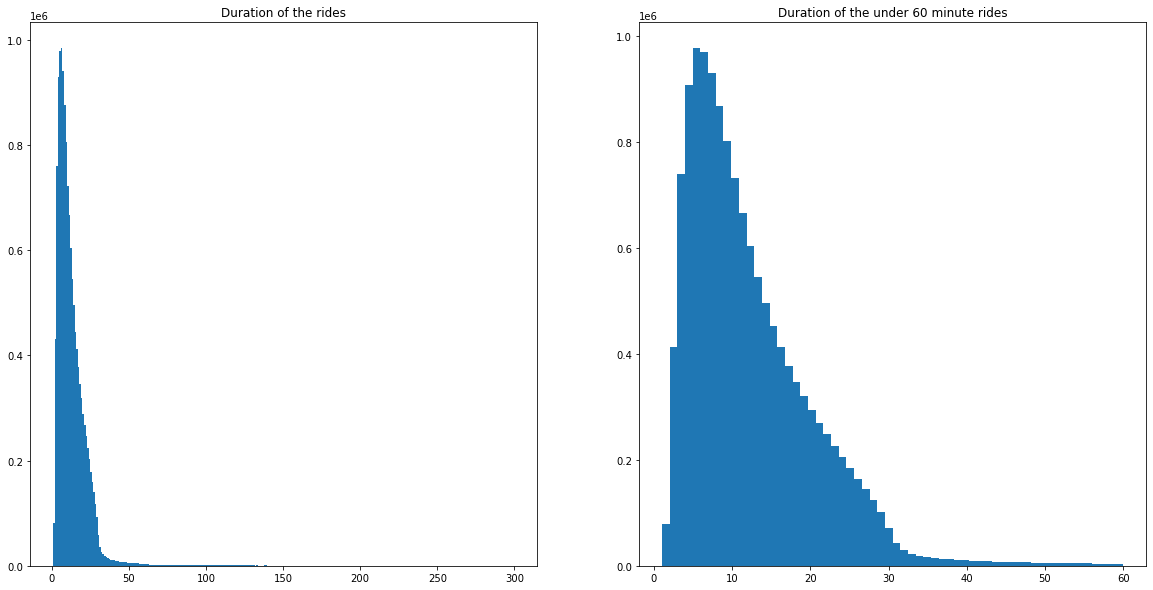

In [35]:
f, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].hist(bike_df['Duration'], bins=300)
axs[0].title.set_text('Duration of the rides')
axs[1].hist(bike_df[bike_df['Duration'] <= 60]['Duration'], bins=60)
axs[1].title.set_text('Duration of the under 60 minute rides')
plt.show()

The graps show that large majority of the rides are short, and most rides are under 30 minutes. The paying model encourages the users to take short rides. The chart showing only rides under 60 minutes show that the peak is slightly under 10 minutes. 

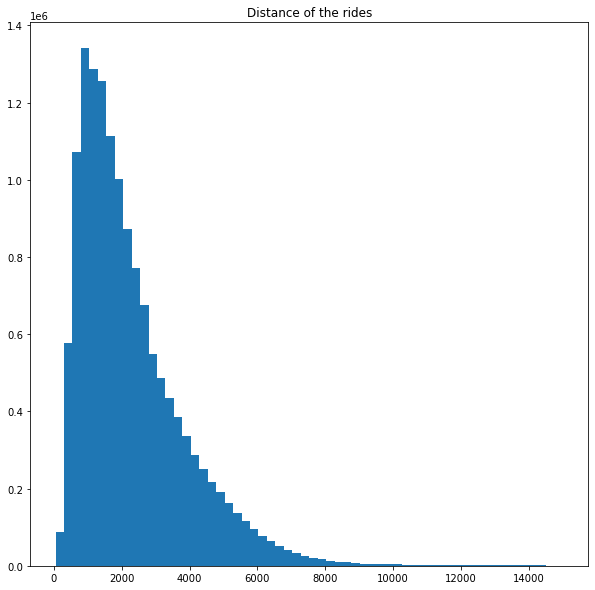

In [36]:
f, axs = plt.subplots(figsize=(10,10))
plt.hist(bike_df['Distance'], bins=60)
plt.title('Distance of the rides')
plt.show()


The distance graph is similar to the duration graphs, with the majority of trips being short and peak in slightly under 2 kilometers.

Hourly departures are counted and combined with the weather data set.

In [37]:
hourly_usage = bike_df.groupby([pd.Grouper(key='Departure',freq='H')]).size().reset_index(name='Count').set_index('Departure')

df = pd.merge_asof(hourly_usage, weather_df, left_index=True, right_index=True, tolerance=pd.Timedelta(1,'m'))
df.dropna(inplace=True)
df

,Count,Precip,Temp
Departure,,,
2016-05-02 14:00:00,1,0.0,15.0
2016-05-02 15:00:00,34,0.0,14.8
2016-05-02 16:00:00,88,0.0,14.5
2016-05-02 17:00:00,103,0.0,14.9
2016-05-02 18:00:00,93,0.0,15.5
...,...,...,...
2021-10-31 19:00:00,220,0.0,9.8
2021-10-31 20:00:00,195,0.0,9.8
2021-10-31 21:00:00,102,0.0,9.7


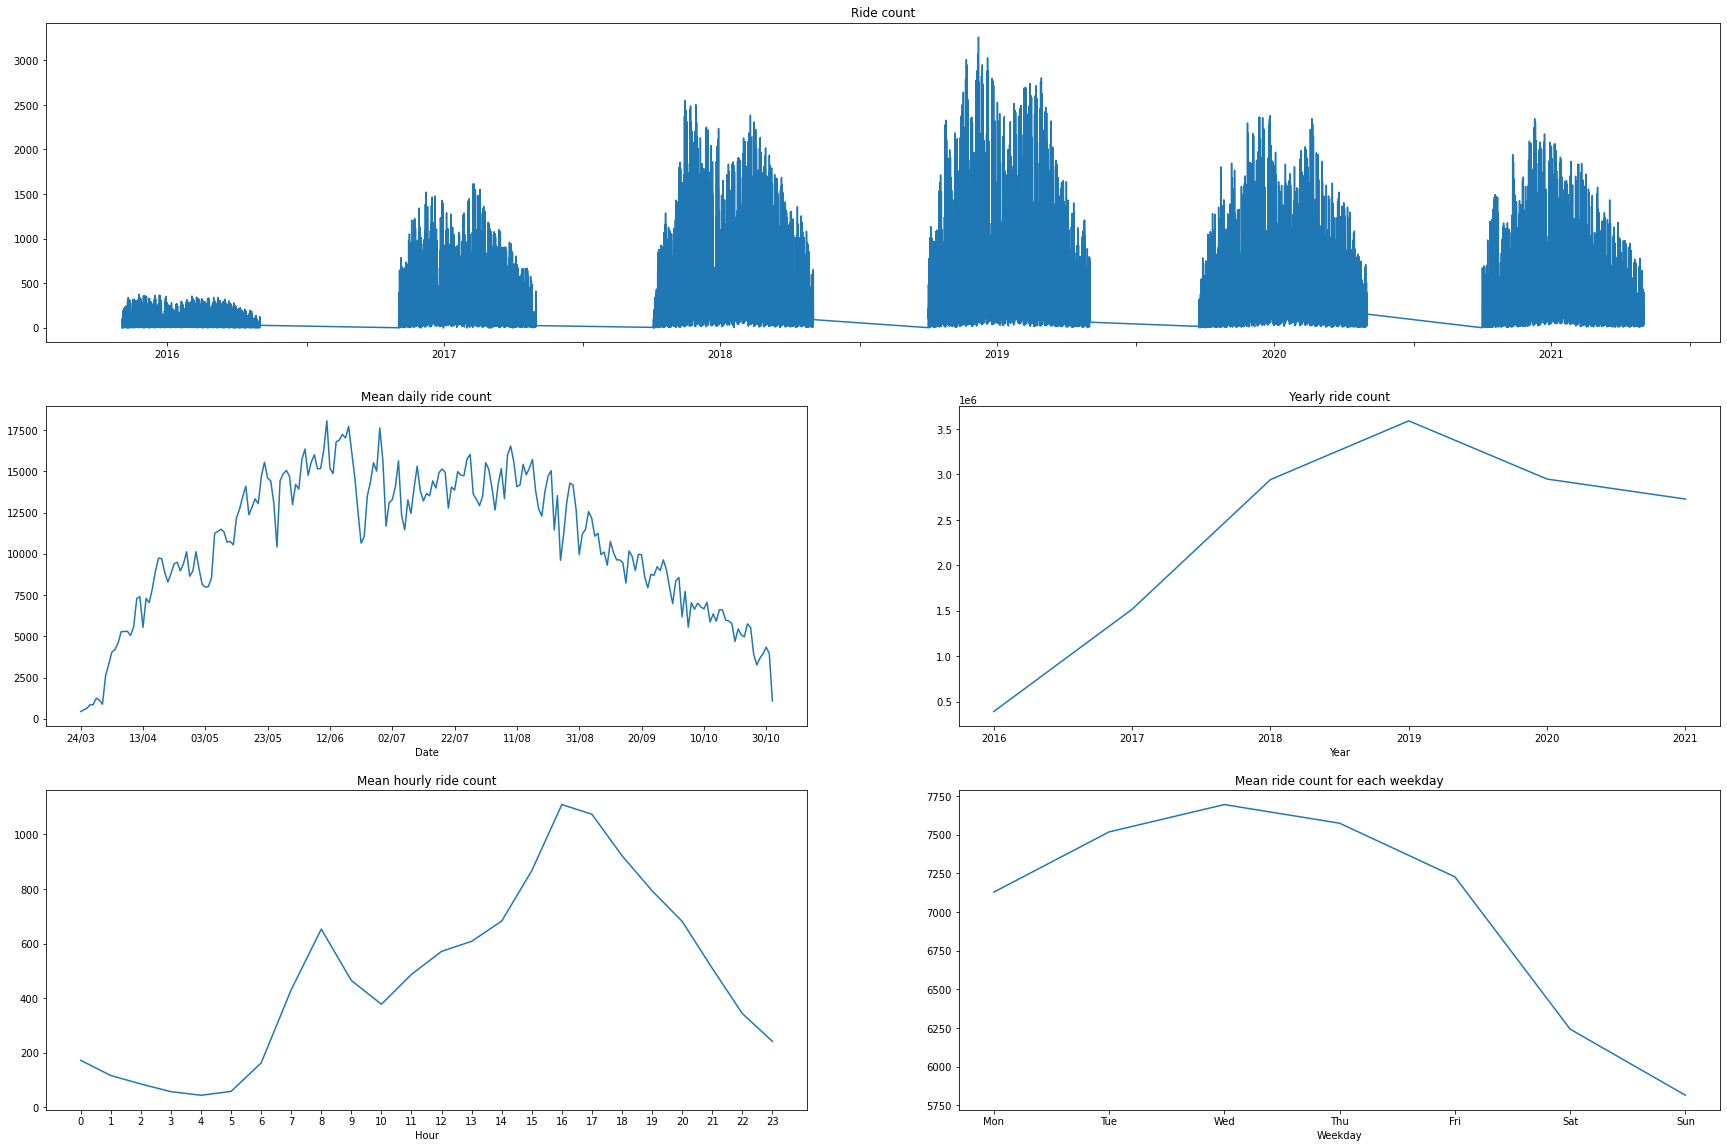

In [38]:
f, axs = plt.subplot_mosaic("AA;BC;DE", figsize=(30,20))

df_daily = df.resample('d').sum()

axs["A"].plot(df['Count'])
axs["A"].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs["A"].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
[l.set_visible(False) for (i,l) in enumerate(axs["A"].xaxis.get_ticklabels()) if i % 2 != 0]
axs["A"].title.set_text('Ride count')

day_of_year_mean = df_daily.groupby([df_daily.index.day_of_year])['Count'].mean()
day_of_year_mean.index = pd.to_datetime(day_of_year_mean.index, format='%j').strftime('%d/%m')
axs["B"].plot(day_of_year_mean[day_of_year_mean > 0])
axs["B"].xaxis.set_major_locator(plt.MaxNLocator(14))
axs["B"].title.set_text('Mean daily ride count')
axs["B"].set_xlabel('Date')


axs["C"].plot(df.groupby([df.index.year])['Count'].sum())
axs["C"].title.set_text('Yearly ride count')
axs["C"].set_xlabel('Year')

axs["D"].plot(df.groupby([df.index.hour])['Count'].mean())
axs["D"].set_xticks(np.arange(0,24))
axs["D"].title.set_text('Mean hourly ride count')
axs["D"].set_xlabel('Hour')

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axs["E"].plot(df_daily.groupby([df_daily.index.weekday])['Count'].mean())
axs["E"].set_xticks(np.arange(0, 7))
axs["E"].set_xticklabels(weekdays)
axs["E"].title.set_text('Mean ride count for each weekday')
axs["E"].set_xlabel('Weekday')
plt.show()

The city bike season started at the beginning of May in 2016-2017, late March in 2020, and at the beginning of April in 2018, 2019, and 2021. It ended each year at the end of October.

The demand has risen significantly since 2016, it peaked in 2019 and has decreased slightly since. The shared electric scooter services started in Helsinki in 2019 and in Espoo in 2020 ([Source in Finnish](https://tieto.traficom.fi/fi/tilastot/yhteiskayttoisten-sahkopotkulautapalveluiden-tarjonta-kysynta-ja-markkinatilanne)), and since the scooters are an alternative to city bikes in short distances, they are most likely the major reason for the decrease in city bike trips. 

The mean daily ride count has a drop at the beginning of May which can be explained by bikes being available in March and April in the later years when the demand was higher. There is another large drop in late June, which is due to Midsummer (Juhannus), and fewer people in the cities.

The daily and weekly trends show that bikes are used frequently as a part of the commute to school and work. The peak is in the morning at eight, and the most demand is in the afternoon and early evening when people are often commuting to or from work and school. The lower usage during the weekends also indicates that the bikes are not utilized as much for leisure. The following graph shows the daily difference between the weekdays and weekends.

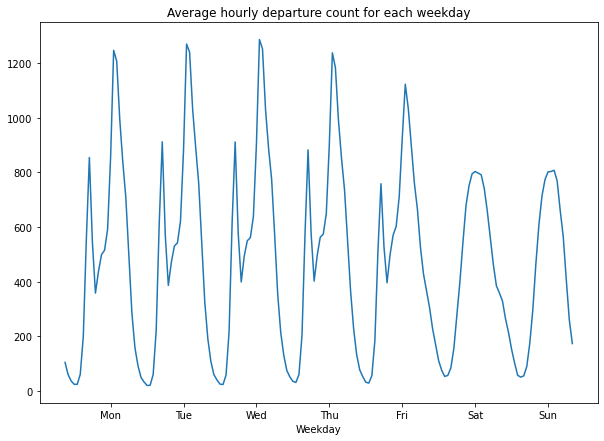

In [39]:
f, ax = plt.subplots(figsize=(10,7))
ax.plot(df.groupby([df.index.weekday, df.index.hour])["Count"].mean().droplevel(1).values)
ax.set_xticks(np.arange(15, 168, 24))
ax.title.set_text('Average hourly departure count for each weekday')
ax.set_xlabel('Weekday')
ax.set_xticklabels(weekdays)

plt.show()

The daily trend is different between the weekdays and weekends. On weekdays the trend follows typical working hours, with a peak in the morning before the start of the workday and a larger and wider peak in the late afternoon and early evening after typical working hours. On weekends, the peak is wider but lower, with more balanced usage during the middle of the day.

In [41]:
top_stations = bike_df.groupby(['Departure_name']).size().sort_values(ascending=False).head(10).index
top_stations = pd.DataFrame(top_stations).rename(columns={'Departure_name': 'Departure station'})

top_pairs = bike_df.groupby(['Departure_name', 'Return_name']).size().sort_values(ascending=False).head(10).index.tolist()
top_pairs = pd.DataFrame(top_pairs).rename(columns={0: 'Departure station', 1: 'Return station'})

desc1 = top_stations.style.set_table_attributes("style='display:inline'").set_caption('Most used stations')
desc2 = top_pairs.style.set_table_attributes("style='display:inline'").set_caption('Most frequent station pairs')
display_html(desc1._repr_html_()+desc2._repr_html_(), raw=True)

,Departure station
0,Itämerentori
1,Töölönlahdenkatu
2,Kamppi (M)
3,Ympyrätalo
4,Rautatientori / länsi
5,Rautatientori / itä
6,Hietalahdentori
7,Sörnäinen (M)
8,Kalasatama (M)
9,Ooppera


The only station occurring on both lists is Itämerentori, which indicates that the most used are near transportation hubs and have multiple connections. The most frequent pairs show the most used routes, and most station pairs appear both ways on the list.

## Predicting the number of hourly bike rides 

The demand of the city bikes has seasonal trends, and in this section, we try to predict the hourly demand using two models, a linear model and a tree  based model. 

## Preprocessing

Since the consecutive values in timeseries are often heavily correlated, lag columns for the previous three hours are added. The daily trend was also strong and thus, lag column that contains the count value from 24 hours prior are ralso added. 

In [42]:
def add_lag_columns(dataframe, column, lags):

    for lag in lags:
        dataframe[f'{column}(t-{str(lag)})'] = dataframe[column].shift(lag, freq='h')

add_lag_columns(df, 'Count', [1, 2, 3, 24])

The data has clear seasonal trends and observation date related features as necessary. As weekends have a different daily trends than weekdays, a categorical weekend column is created.

In [43]:
df['Day'] = df.index.weekday
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['Weekend'] = (df.index.weekday > 4).astype(int)
df['Year'] = df.index.year

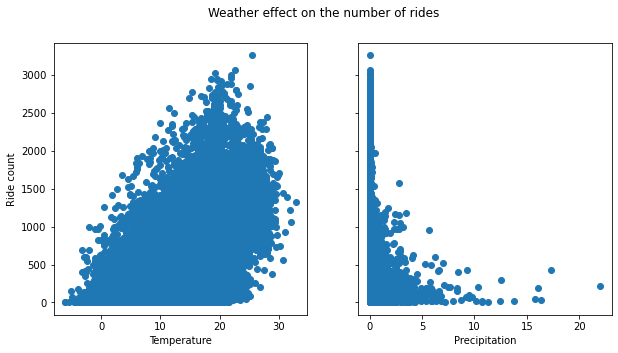

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].scatter(df.Temp, df.Count)
axs[0].set_ylabel('Ride count')
axs[0].set_xlabel('Temperature')

axs[1].scatter(df.Precip, df.Count)
axs[1].set_xlabel('Precipitation')

plt.suptitle('Weather effect on the number of rides')
plt.show()

The weather observations were made in Kaisaniemi, and the weather may have varied at the different bike stations. This might decrease the correlation between weather observations and the number of bike rides. 

The temperatures appear to be positively correlated with the number of rides, as the number of high ride counts occurs more as the temperature rises. Since the large majority of the precipitation values are at or near zero, the correlation between the number of rides and the precipitation amount is not as clear. 

The amount of precipitation might not matter to the users much. It seems that even a small amount of rain will deter users from using the bikes. Adding rain as a categorical variable may provide more information than just the amount of rain. 

In [45]:
df['Rain'] = (df['Precip'] > 0).astype(int)

## Prediction

Absolute mean error, root mean squared error, and R2 score to evaluate the cross-validation results, and mean and median absolute error and R2 score to evaluate the performance on the test set.

In [46]:
def evaluate(model, X, y, splits):
  cv_score = cross_validate(model, X, y, cv=splits, 
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])
  abs_error = -cv_score["test_neg_mean_absolute_error"]
  rmse = np.sqrt(-cv_score["test_neg_mean_squared_error"])
  r2 = cv_score["test_r2"]

  print(f'Mean absolute error: {abs_error.mean():.3f} +/- {abs_error.std():.3f}')
  print(f'RMSE: {rmse.mean():.3f} +/- {rmse.std():.3f}')
  print(f'R2: {r2.mean():.3f} +/- {r2.std():.3f}')


def results(y_true, y_preds):
    print(f'Mean absolute error: {metrics.mean_absolute_error(y_true, y_preds):.2f}')
    print(f'Median absolute error: {metrics.median_absolute_error(y_true, y_preds):.2f}')
    print(f'R2: {metrics.r2_score(y_true, y_preds):.3f}')

In [47]:
df.dropna(inplace=True)

X = df.drop(["Count"], axis=1)
y = df["Count"]
y.head()

Departure
2016-05-03 14:00:00    116
2016-05-03 15:00:00     97
2016-05-03 16:00:00    192
2016-05-03 17:00:00    154
2016-05-03 18:00:00    140
Name: Count, dtype: int64

The data from the last year is used as the test set and the data from the previous years as training set.

In [48]:
X_train = X.loc[X.index.year < 2021]
X_test = X.loc[X.index.year == 2021]
y_train = y.loc[y.index.year < 2021]
y_test = y.loc[y.index.year == 2021]

Since the data is time-ordered, a time-sensitive splitter to create the splits is used to create ten splits for cross-validation. With TimeSeriesSplit successive splits are supersets of all the previous splits. The training set size is limited to 15000 to limit the difference between the sizes of the first and last splits. This should decrease the variation between the results of the splits. Approximately two months of data are used for the test splits, which is 1460 test data points.

In [50]:
ts_cv = TimeSeriesSplit(n_splits=10, max_train_size=15000, test_size=1460)
splits = list(ts_cv.split(X_train, y_train))

### Linear model
The linear model requires a lot more encoding than the tree-based model. The periodical columns Day, Month, and Hour are encoded using sine and cosine transformation to two features each. The categorical columns are encoded using one-hot encoding, and the numerical columns are normalized using min-max normalization. 

In [51]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [52]:
lin_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(sparse_output=False), ["Weekend", "Rain"]),
            ("month_sin", sin_transformer(12), ["Month"]),
            ("month_cos", cos_transformer(12), ["Month"]),
            ("weekday_sin", sin_transformer(7), ["Day"]),
            ("weekday_cos", cos_transformer(7), ["Day"]),
            ("hour_sin", sin_transformer(24), ["Hour"]),
            ("hour_cos", cos_transformer(24), ["Hour"]),
            ("numerical", MinMaxScaler(), ['Precip', 'Temp', 'Count(t-1)', 'Count(t-2)', 'Count(t-3)', 'Count(t-24)'])
            ],
        remainder="passthrough",
        verbose_feature_names_out=False
    ),
    LinearRegression()
)

evaluate(lin_pipeline, X_train, y_train, splits)

Mean absolute error: 111.388 +/- 25.280
RMSE: 160.261 +/- 39.919
R2: 0.898 +/- 0.029


### Tree based model

The model used is a histogram-based Gradient Boosting Regression Tree, utilizing HistGradientBoostingRegressor-model from sklearn-package. With this model the variables do not need preprocessing.

In [53]:
grad_model =  HistGradientBoostingRegressor(categorical_features=["Weekend", "Rain"], random_state=0)

evaluate(grad_model, X_train, y_train, splits)

Mean absolute error: 68.514 +/- 22.896
RMSE: 109.730 +/- 39.619
R2: 0.952 +/- 0.026


The histogram boosting model outperforms the linear model with every metric.

The histogram boosting model has manhy hyper-paraters that might require tuning to optimize the results. We tune three parameters:

- Learning rate
    - default value 0.1
    - Try values 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2

- Max iterations
    - Default 100
    - Try values 100, 200, 500

- l2 regularization
    - Default 0
    - Try values 0, 0.001, 0.01, 0.1

The mean absolute error to evaluate the models, and the parameters with the lowest mean absolute error are selected.

In [54]:
params =  {
    'learning_rate': np.arange(0.04, 0.21, 0.02),
    'max_iter': [100, 200, 500],
    'l2_regularization': [0, 0.001, 0.01, 0.1]
}

clf = GridSearchCV(grad_model, params, cv=splits, n_jobs=-1, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

clf.best_params_

{'l2_regularization': 0.001, 'learning_rate': 0.06, 'max_iter': 500}

Create a new model using the tuned parameters

In [55]:
grad_model =  HistGradientBoostingRegressor(
    categorical_features=["Weekend", "Rain"],
    l2_regularization=clf.best_params_['l2_regularization'],
    learning_rate=clf.best_params_['learning_rate'],
    max_iter=clf.best_params_['max_iter'],
    random_state=0
)

In [59]:
lin_preds = lin_pipeline.fit(X_train, y_train).predict(X_test)
grad_preds = grad_model.fit(X_train, y_train).predict(X_test)

print("Linear model:")
results(y_test, lin_preds)

print()
print("Gradient boosting regression trees:")
results(y_test, grad_preds)

Linear model:
Mean absolute error: 84.72
Median absolute error: 58.68
R2: 0.934

Gradient boosting regression trees:
Mean absolute error: 46.83
Median absolute error: 26.57
R2: 0.969


The results of the gradient boosting regression trees are significantly better than the results of the linear model with every evaluation metric used. The mean absolute error is approximately 38 lower, and meadian aboslute error is approximately 32 lower. 

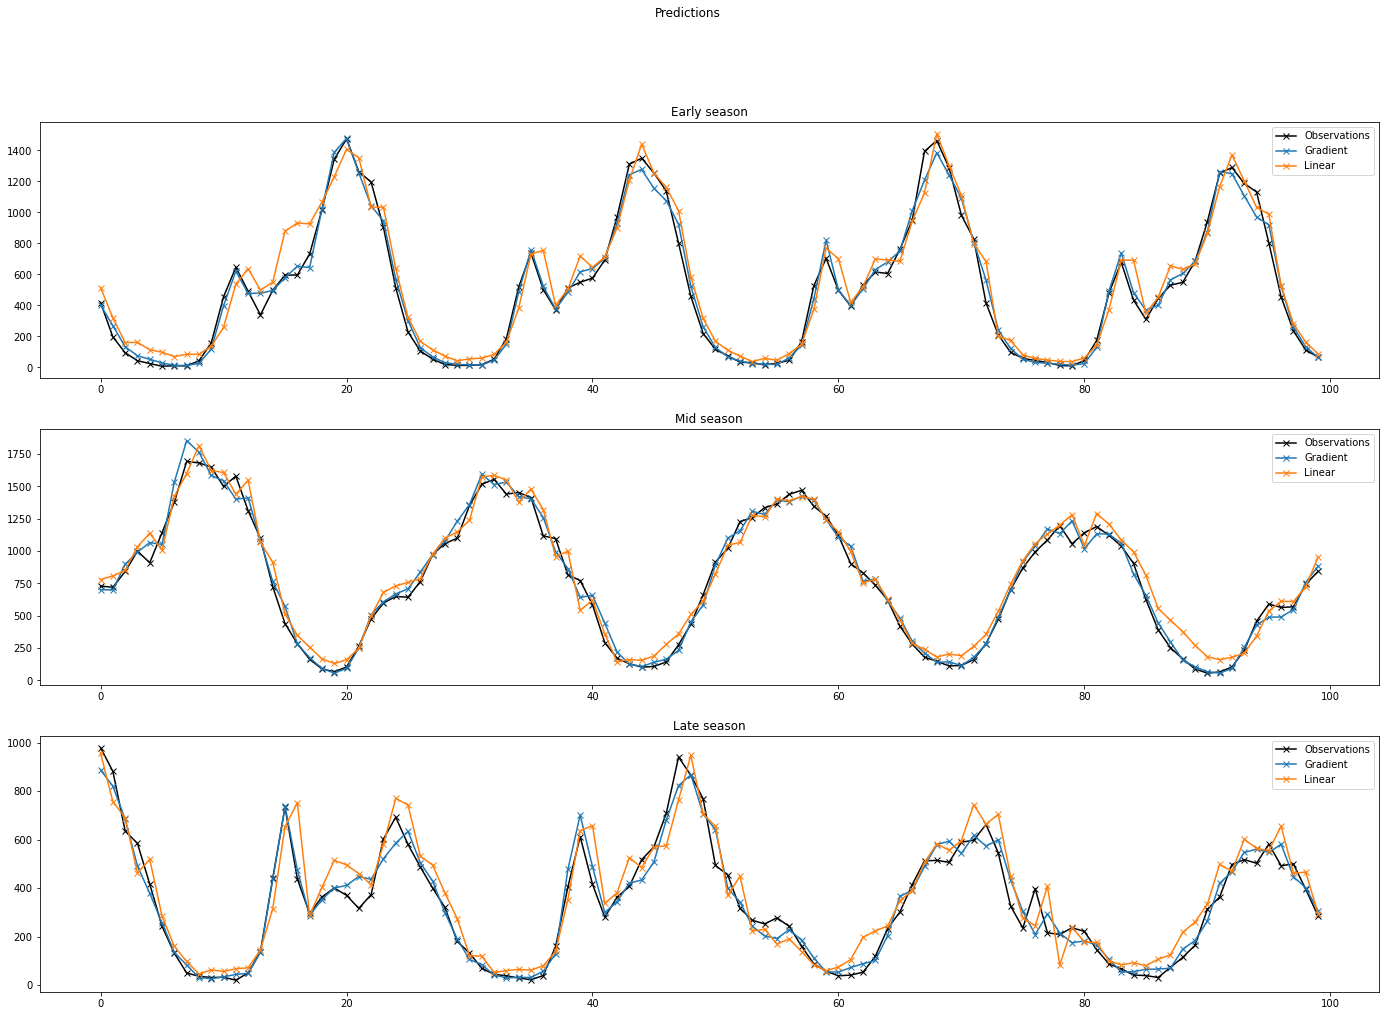

In [181]:
fig, ax = plt.subplots(3, 1, figsize=(24, 16))
fig.suptitle("Predictions")
start_ind = [400, 2500, 4500]
titles = ["Early season", "Mid season", "Late season"]


for i in range(3):
    ax[i].plot(
        y_test[start_ind[i]: start_ind[i] + 100].to_numpy(),
        "x-",
        label="Observations",
        color="black",
    )
    ax[i].plot(
        grad_preds[start_ind[i]: start_ind[i] + 100],
        "x-",
        label="Gradient",
    )
    ax[i].plot(
        lin_preds[start_ind[i]: start_ind[i] + 100],
        "x-",
        label="Linear",
    )
    ax[i].title.set_text(titles[i])
    _ = ax[i].legend()

The graph shows 100 hour slices from the test set from different points of the season. The first is from the early season, second in the middle, and the last near the end of the season. Both models appear to struggle more in the late season when the overall demand is lower. 

The predictions of the linear model seems to follow the daily trend quite well, although it seems to consistently overestimate the demand for the bikes. The overestimation appears to increase during the night when the demand is lowest. 

The gradient boosting model predicts the demand much more accurately, with the predictions closely matching the observation at both high and low demand.

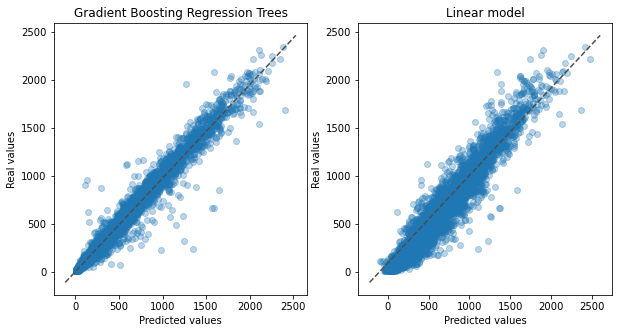

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(grad_preds, y_test, alpha=0.3)
axs[0].plot(axs[0].get_xlim(), axs[0].get_ylim(), ls="--", c=".3")
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Real values')
axs[0].title.set_text('Gradient Boosting Regression Trees')

axs[1].scatter(lin_preds, y_test, alpha=0.3)
axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), ls="--", c=".3")
axs[1].set_xlabel('Predicted values')
axs[1].set_ylabel('Real values')
axs[1].title.set_text('Linear model')

plt.show()

The performance of the gradient boosting model is significantly better than the performance of linear model. It avoids over- or underestimating the demand with any values and follows the optimal line consistetly. As observed form the previous plots, the linear model overestimates the demand when the demand is low, and it also underestimates the demand when the demand is high, which was not visible in the previous plots.

## Conclusions

City bikes are a popular method of transportation for short distances in Helsinki and Espoo, and their popularity has risen significantly since they were deployed. Alternative transportation methods, such as electric scooters have most likely affected bike usage, which decreased slightly after 2019 when the first electric scooters were deployed, and it might continue decreasing with more competition. The usage of bikes is seasonal, and the monthly and weekly trends are easy to observe. 

With gradient-boosting regression trees, predicting the hourly demand for the bikes was more accurate than with a linear model. The gradient boosting model predicted the demand with a mean absolute error of 47 and a median absolute error of 27. 

The demand was predicted for only one hour in the future, and being able to predict it further away in the future would be more useful. The overall demand might also not be as interesting and useful as the demand at a specific station, and the data from specific stations could be used to find the hub stations and utilized to predict the commuting routes. A station must have available bikes if a user wants to use them, and instead of predicting the demand, predicting the difference between the departures and returns at a station might be more useful to ensure that a station has enough bikes for all the users.